In [ ]:
# load data file
import requests

# URL of data file from github
data_file_url = "https://raw.githubusercontent.com/thnhan1/bigdata-process2/main/data/WebOfScience-5736.txt"

response = requests.get(data_file_url)

if response.status_code == 200:
    # save file to colab folder
    with open('/content/WebOfScience-5736.txt', 'wb') as f:
        f.write(response.content)
    print("download file successfully")
    data_path = '/content/WebOfScience-5736.txt'
else:
    print("Error URL:", response.status_code)


download file successfully


In [ ]:
import hashlib
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

def stable_hash(x, mod=1000):
    """ Tạo một hash ổn định dựa trên input và mod. """
    return int(hashlib.sha256(x.encode('utf-8')).hexdigest(), 16) % mod

class InMemoryMinHashLSH:
    def __init__(self, documents: pd.DataFrame, k=2, num_permutations=100):
        self.documents = documents
        self.k = k
        self.vocab = None
        self.vector_booleans = None
        self.signatures = None
        self.buckets = None
        self.signatures_df = None
        self.buckets_df = None
        self.num_permutations = num_permutations
        self.permutations = []

    def shingling(self, documents):
        shingle_sets = []
        full_set = set()
        for text in documents['text']:
            words = text.split()
            shingles = {' '.join(words[i:i+self.k]) for i in range(len(words) - self.k + 1)}
            shingle_sets.append(shingles)
            full_set.update(shingles)
        self.vocab = {shingle: i for i, shingle in enumerate(full_set)}

        # Initialize permutations based on the correct vocabulary size
        self.permutations = [np.random.permutation(len(self.vocab)) for _ in range(self.num_permutations)]

        rows, cols, data = [], [], []
        for doc_idx, shingles in enumerate(shingle_sets):
            for shingle in shingles:
                rows.append(doc_idx)
                cols.append(self.vocab[shingle])
                data.append(1)
        return pd.DataFrame(csr_matrix((data, (rows, cols)), shape=(len(documents), len(self.vocab))).toarray())

    def minhashing(self, bool_vectors):
        num_docs = bool_vectors.shape[0]
        signatures = np.full((num_docs, self.num_permutations), np.inf)

        for i, permutation in enumerate(self.permutations):
            for j in range(num_docs):
                column_indices = np.where(bool_vectors.iloc[j] > 0)[0]
                if column_indices.size > 0:
                    row_perm = permutation[column_indices]
                    min_perm = np.min(row_perm)
                    signatures[j, i] = min_perm
        self.signatures = signatures
        return pd.DataFrame({'signatures': [list(signatures[i, : ]) for i in range(num_docs)]})

    def locality_sensity_hashing(self, signatures):
        num_docs = signatures.shape[0]
        num_cols = signatures.shape[1]

        num_bands = 20
        r = num_cols // num_bands
        buckets = {}

        for doc_idx in range(num_docs):
            signature = tuple(signatures[doc_idx, : ])
            combined_hash = 0
            for band_idx in range(num_bands):
                start = band_idx * r
                end = start + r
                subvec = tuple(signature[start:end])
                bucket_id = stable_hash(str(subvec))
                if bucket_id not in buckets:
                    buckets[bucket_id] = []
                buckets[bucket_id].append(doc_idx)
        self.buckets = buckets
        bucket_list = [{'bucket_id': key, 'document_indices': value} for key, value in buckets.items()]
        return pd.DataFrame(bucket_list)

    def approxNearestNeighbors(self, new_document, n):
        # Step 1: Shingling
        words = new_document.split()
        shingles = {' '.join(words[i:i+self.k]) for i in range(len(words) - self.k + 1)}
        vector = np.zeros(len(self.vocab))
        for shingle in shingles:
            if shingle in self.vocab:
                vector[self.vocab[shingle]] = 1

        # Step 2: Minhashing for new document
        query_signature = np.full(self.num_permutations, np.inf)
        for i, permutation in enumerate(self.permutations):
            column_indices = np.where(vector > 0)[0]
            if column_indices.size > 0:
                row_perm = permutation[column_indices]
                min_perm = np.min(row_perm)
                query_signature[i] = min_perm

        # Step 3: Locality-Sensitive Hashing
        num_bands = 20
        r = self.num_permutations // num_bands
        query_buckets = set()


        for band_idx in range(num_bands):
            start = band_idx * r
            end = start + r
            subvec = tuple(query_signature[start:end])
            bucket_id = stable_hash(str(subvec))
            query_buckets.add(bucket_id)

        # Step 4: Collect candidates from same buckets
        candidates = set()
        for bucket_id in query_buckets:
            if bucket_id in self.buckets:
                candidates.update(self.buckets[bucket_id])

        # Step 5: Calculate Jaccard similarities
        similarities = []
        for candidate in candidates:
            candidate_signature = self.signatures[candidate]
            intersection = np.sum(np.minimum(query_signature, candidate_signature))
            union = np.sum(np.maximum(query_signature, candidate_signature))
            similarity = intersection / union
            similarities.append({'similarity': similarity, 'document_index': candidate})

        # Create DataFrame from similarities and sort by similarity
        results_df = pd.DataFrame(similarities)
        results_df.sort_values(by='similarity', ascending=False, inplace=True)

        # Return top N results as DataFrame
        return results_df.head(n)

    def run(self):
        self.vector_booleans = self.shingling(self.documents)
        self.signatures_df = self.minhashing(self.vector_booleans)
        self.buckets_df = self.locality_sensity_hashing(self.signatures)

file_path = data_path

with open(file_path, 'r') as file:
    lines = file.readlines()
documents_df = pd.DataFrame({"text": lines})

minhash_lsh = InMemoryMinHashLSH(documents_df)
minhash_lsh.run()
results = minhash_lsh.approxNearestNeighbors('Background: The lack of early diagnosis, progression markers and effective pharmacological treatment has dramatic unfavourable effects on clinical outcomes in patients with peripheral artery disease (PAD). Addressing these issues will require dissecting the molecular mechanisms underlying this disease. We sought to characterize the Notch signaling and atherosclerosis relevant markers in lesions from femoral arteries of symptomatic PAD patients. Methods: Plaque material from the common femoral, superficial femoral or popliteal arteries of 20 patients was removed by directional atherectomy. RNA was obtained from 9 out of 20 samples and analysed by quantitative reverse transcriptase-polymerase chain reaction (qRT-PCR). Results: We detected expression of Notch ligands Delta-like 4 (Dll4) and Jagged1 (Jag1), of Notch target genes Hes1, Hey1, Hey2, HeyL and of markers of plaque inflammation and stability such as vascular cell adhesion molecule 1 (VCAM1), smooth muscle 22 (SM22), cyclooxygenase 2 (COX2), Bcl2, CD68 and miRNAs 21-5p, 125a-5p, 126-5p, 146-5p, 155-5p, 424-5p. We found an "inflamed plaque" gene expression profile characterized by high Dll4 associated to medium/high CD68, COX2, VCAM1, Hes1, miR126-5p, miR146a-5p, miR155-5p, miR424-5p and low Jag1, SM22, Bcl2, Hey2, HeyL, miR125a-5p (2/9 patients) and a "stable plaque" profile characterized by high Jag1 associated to medium/high Hey2, HeyL, SM22, Bcl2, miR125a and low Dll4, CD68, COX2, VCAM1, miR126-5p, miR146a-5p, miR155-5p, miR424-5p (3/9 patients). The remaining patients (4/9) showed a plaque profile with intermediate characteristics. Conclusions: This study reveals the existence of a gene signature associated to Notch activation by specific ligands that could be predictive of PAD progression.', n=10)
print(results)

      similarity  document_index
1497    1.000000            4503
1821    0.432430            5495
250     0.426303             760
1541    0.422202            4632
1873    0.421671            5653
181     0.420345             545
1356    0.419240            4105
1772    0.417277            5357
1115    0.417129            3392
1680    0.414183            5087


In [ ]:
results = minhash_lsh.approxNearestNeighbors('The lack of early diagnosis', n=10)
print(results)

      similarity  document_index
1086    0.263499            3270
1085    0.229540            3268
1425    0.198221            4266
1785    0.145594            5416
998     0.135858            2944
98      0.130459             307
1455    0.130152            4355
444     0.123756            1305
1130    0.111773            3389
778     0.106638            2351


In [ ]:
print(documents_df.at[4266, 'text'])

This article presents an overview of nonaccidental trauma in children, including common clinical presentation, evaluation, and diagnosis.



In [ ]:
print(minhash_lsh.vector_booleans)

      0       1       2       3       4       5       6       7       8       \
0          0       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          0       0       0       0       0       0       0       0       0   
3          0       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5731       0       0       0       0       0       0       0       0       0   
5732       0       0       0       0       0       0       0       0       0   
5733       0       0       0       0       0       0       0       0       0   
5734       0       0       0       0       0       0       0       0       0   
5735       0       0       0       0       0       0       0       0       0   

      9       ...  539673  539674  5396

In [ ]:
print(minhash_lsh.signatures_df)

                                             signatures
0     [230.0, 426.0, 5121.0, 2404.0, 2264.0, 332.0, ...
1     [4144.0, 3062.0, 4521.0, 278.0, 4539.0, 1615.0...
2     [6901.0, 3493.0, 2971.0, 800.0, 1595.0, 1210.0...
3     [316.0, 3118.0, 296.0, 3099.0, 7611.0, 2761.0,...
4     [3574.0, 3987.0, 1067.0, 1485.0, 1674.0, 808.0...
...                                                 ...
5731  [610.0, 290.0, 4794.0, 9870.0, 24.0, 1492.0, 9...
5732  [11469.0, 1491.0, 9495.0, 2416.0, 4769.0, 399....
5733  [5778.0, 6556.0, 920.0, 1079.0, 411.0, 2488.0,...
5734  [3670.0, 7312.0, 4908.0, 3342.0, 2915.0, 1170....
5735  [5873.0, 10972.0, 1660.0, 11854.0, 440.0, 2630...

[5736 rows x 1 columns]


In [ ]:
print(minhash_lsh.buckets)

{240: [0, 44, 118, 194, 255, 291, 475, 521, 538, 556, 586, 606, 705, 705, 923, 961, 1096, 1104, 1137, 1139, 1230, 1247, 1282, 1463, 1540, 1571, 1652, 1664, 1781, 1783, 1882, 2000, 2042, 2150, 2160, 2275, 2290, 2346, 2392, 2432, 2452, 2552, 2671, 2679, 2754, 2759, 2914, 2938, 3060, 3065, 3117, 3165, 3176, 3186, 3257, 3349, 3393, 3494, 3592, 3603, 3699, 3959, 3969, 3994, 3996, 4052, 4075, 4170, 4203, 4300, 4340, 4425, 4428, 4437, 4455, 4701, 4861, 5051, 5141, 5176, 5176, 5257, 5258, 5282, 5333, 5334, 5369, 5372, 5453, 5478, 5480, 5511, 5526, 5613, 5635, 5676, 5703], 968: [0, 12, 58, 92, 202, 231, 338, 364, 379, 517, 535, 653, 653, 660, 778, 788, 857, 911, 962, 1065, 1104, 1150, 1181, 1223, 1254, 1309, 1341, 1381, 1404, 1418, 1489, 1506, 1621, 1621, 1630, 1683, 1691, 1693, 1738, 1760, 1794, 1805, 1822, 1898, 1921, 1974, 2024, 2060, 2064, 2172, 2297, 2433, 2447, 2567, 2568, 2597, 2649, 2677, 2722, 2817, 2843, 2975, 2994, 3007, 3093, 3102, 3107, 3240, 3370, 3390, 3426, 3568, 3606, 3745, 374

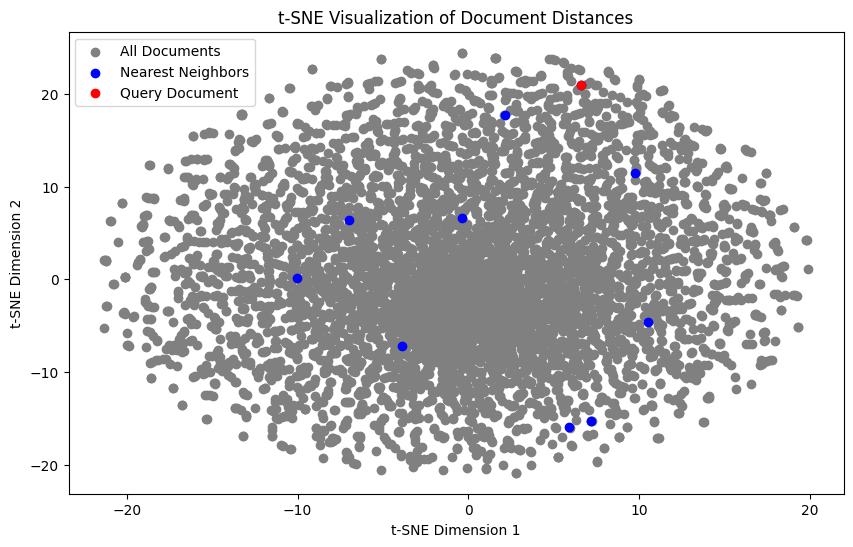

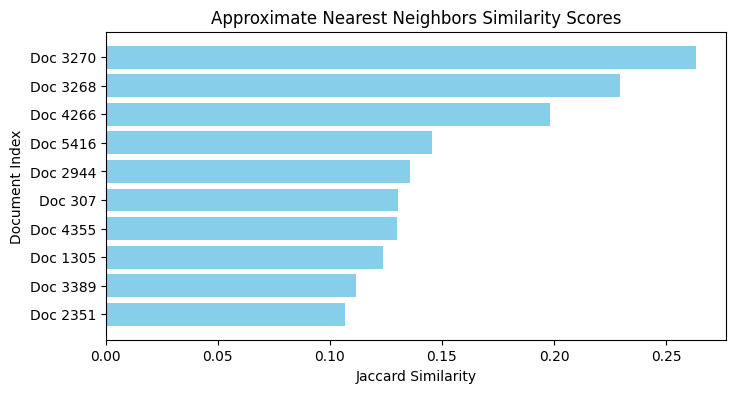

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_nearest_neighbors(minhash_lsh, query_document, n_neighbors):
    # Run the approxNearestNeighbors function
    results = minhash_lsh.approxNearestNeighbors(query_document, n_neighbors)

    # Retrieve signatures for t-SNE
    # Include the query document signature first
    query_signature = minhash_lsh.signatures[-1]  # Assuming the last one is the query document's signature
    neighbor_indices = results['document_index'].values
    all_signatures = np.vstack([minhash_lsh.signatures, query_signature])
    neighbor_signatures = minhash_lsh.signatures[neighbor_indices]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(all_signatures)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:-n_neighbors-1, 0], reduced_data[:-n_neighbors-1, 1], color='gray', label='All Documents')  # All documents in gray
    plt.scatter(reduced_data[-n_neighbors-1:-1, 0], reduced_data[-n_neighbors-1:-1, 1], color='blue', label='Nearest Neighbors')  # Neighbors in blue
    plt.scatter(reduced_data[-1, 0], reduced_data[-1, 1], color='red', label='Query Document')  # Query in red
    plt.title('t-SNE Visualization of Document Distances')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

    # Show similarity scores in a bar chart
    plt.figure(figsize=(8, 4))
    plt.barh(range(len(results)), results['similarity'], color='skyblue')
    plt.xlabel('Jaccard Similarity')
    plt.ylabel('Document Index')
    plt.title('Approximate Nearest Neighbors Similarity Scores')
    plt.yticks(range(len(results)), [f'Doc {idx}' for idx in results['document_index']])
    plt.gca().invert_yaxis()
    plt.show()

# Usage remains the same
query_doc = 'The lack of early diagnosis'
visualize_nearest_neighbors(minhash_lsh, query_doc, 10)